<a href="https://www.kaggle.com/code/habibulbasher01644/olive-leaf-image-classification?scriptVersionId=221920806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/olive-leaf-image-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Data augmentation

In [3]:
# Define image size
img_height, img_width = 128, 128
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:

# Load images from directory
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

# Get class indices
print(train_generator.class_indices)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.
{'Healthy': 0, 'aculus_olearius': 1, 'olive_peacock_spot': 2}


# Approach 1: Build a Custom CNN Model

In [5]:
# Define a simple CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),  # Prevent overfitting
    keras.layers.Dense(3, activation='softmax')  # 3 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

# Save model
# model.save("olive_cnn_model.h5")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - accuracy: 0.4245 - loss: 1.7924 - val_accuracy: 0.3824 - val_loss: 1.0962
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.4843 - loss: 1.1100 - val_accuracy: 0.3824 - val_loss: 1.0861
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.4415 - loss: 1.1155 - val_accuracy: 0.3824 - val_loss: 1.0057
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.4045 - loss: 1.0580 - val_accuracy: 0.3824 - val_loss: 0.9791
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.4717 - loss: 0.8893 - val_accuracy: 0.3824 - val_loss: 0.9168
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.4275 - loss: 0.8626 - val_accuracy: 0.4868 - val_loss: 0.9045
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.4845 - loss: 0.9498 - val_accuracy: 0.3853 - val_loss: 0.9394
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.4178 - loss: 0.9496 - val_accuracy: 0.626

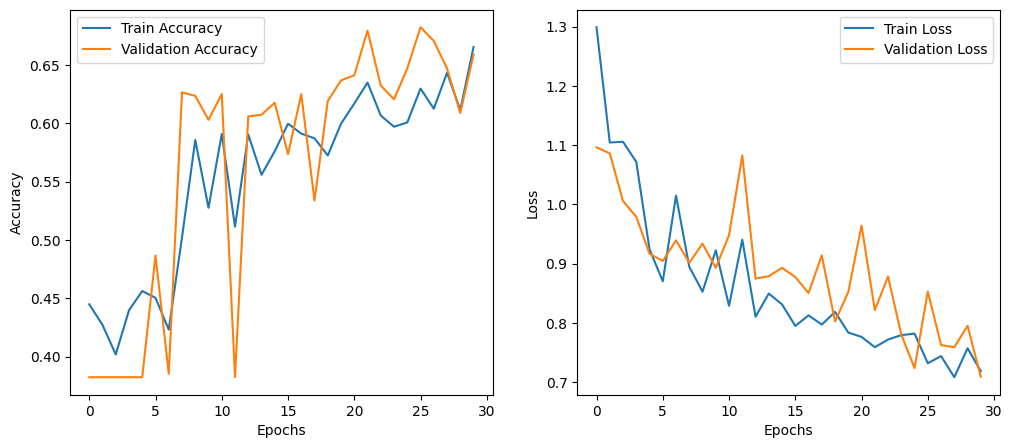

In [9]:
# Plot accuracy & loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [10]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5677 - loss: 0.8777
Test Accuracy: 0.6588


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())  # ['healthy', 'aculus_olearius', 'olive_peacock_spot']
print("Class Labels:", class_labels)
# Predict the test set
steps = test_generator.samples // test_generator.batch_size
y_pred = model.predict(test_generator, steps=steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class indices

# Get actual labels
y_true = test_generator.classes[:len(y_pred_classes)]

Class Labels: ['Healthy', 'aculus_olearius', 'olive_peacock_spot']
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


In [12]:

# Generate and print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)


Confusion Matrix:
 [[113 107   0]
 [ 51 145   4]
 [ 12  58 182]]
Classification Report:
                     precision    recall  f1-score   support

           Healthy       0.64      0.51      0.57       220
   aculus_olearius       0.47      0.72      0.57       200
olive_peacock_spot       0.98      0.72      0.83       252

          accuracy                           0.65       672
         macro avg       0.70      0.65      0.66       672
      weighted avg       0.72      0.65      0.67       672



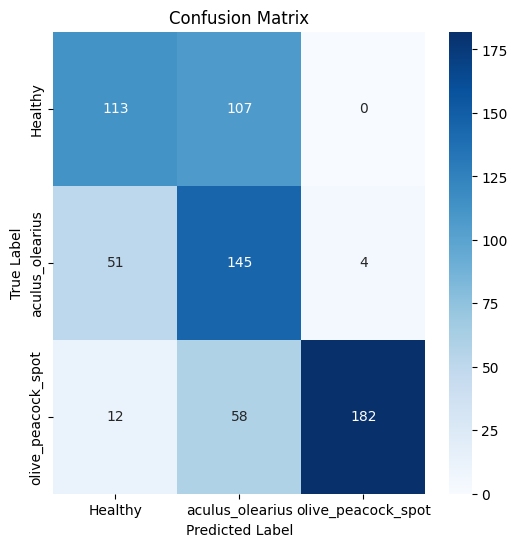

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Approach 2: Use a Pre-trained CNN Model

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [15]:

# Load pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

# Freeze the base model
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

In [17]:

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - accuracy: 0.4464 - loss: 1.7704 - val_accuracy: 0.7368 - val_loss: 0.5973
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.7239 - loss: 0.6419 - val_accuracy: 0.7456 - val_loss: 0.5299
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.8291 - loss: 0.4239 - val_accuracy: 0.8603 - val_loss: 0.3637
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8390 - loss: 0.4186 - val_accuracy: 0.8338 - val_loss: 0.4068
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.8342 - loss: 0.3863 - val_accuracy: 0.8735 - val_loss: 0.3518
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.8468 - loss: 0.3759 - val_accuracy: 0.7853 - val_loss: 0.4568
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.8843 - loss: 0.3203 - val_accuracy: 0.8206 - val_loss: 0.4043
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.8761 - loss: 0.3182 - val_accu

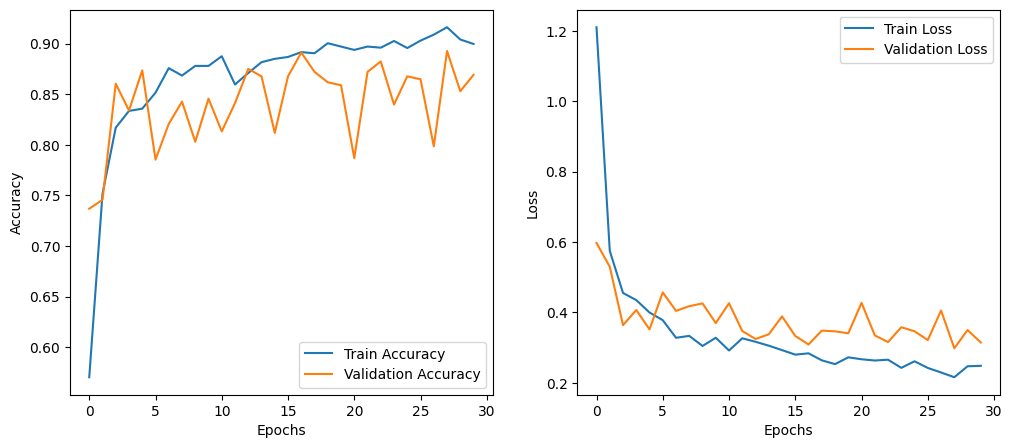

In [19]:
# Plot accuracy & loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8628 - loss: 0.3635
Test Accuracy: 0.8691


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Print class labels to verify order
class_labels = list(test_generator.class_indices.keys())
print("Class Labels:", class_labels)

Class Labels: ['Healthy', 'aculus_olearius', 'olive_peacock_spot']


In [22]:
# Compute the number of steps (using math.ceil to cover all samples)
import math
steps = math.ceil(test_generator.samples / test_generator.batch_size)

# Predict on the test set
y_pred = model.predict(test_generator, steps=steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class indices

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step


In [23]:
# Retrieve the true labels
# Note: test_generator.classes has the labels in the same order as the files (if shuffle=False)
y_true = test_generator.classes

# (Optional) In case there is a mismatch in lengths, ensure they match:
y_pred_classes = y_pred_classes[:len(y_true)]

In [24]:

# Generate and print the confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

Confusion Matrix:
 [[182   5  33]
 [ 10 175  15]
 [ 17   9 234]]
Classification Report:
                     precision    recall  f1-score   support

           Healthy       0.87      0.83      0.85       220
   aculus_olearius       0.93      0.88      0.90       200
olive_peacock_spot       0.83      0.90      0.86       260

          accuracy                           0.87       680
         macro avg       0.88      0.87      0.87       680
      weighted avg       0.87      0.87      0.87       680



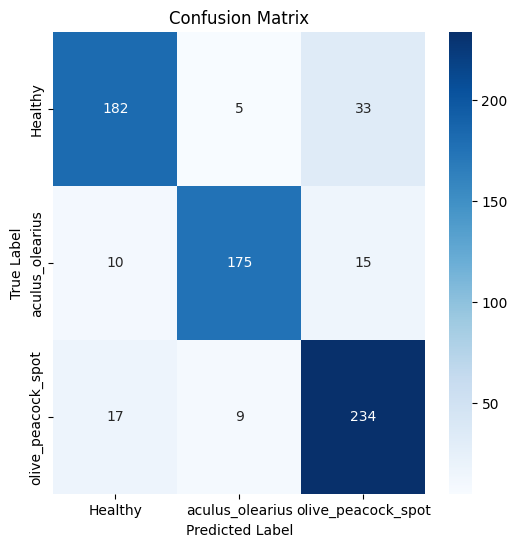

In [25]:
# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
